### **Abstract**
In this project, I focus on cleansing and preparing StackOverflow XML data for further analysis. I begin by converting multiple XML files (e.g., Posts, Users, Comments) into CSV format using Python. After loading and exploring the datasets with pandas, I merge key files to create a unified DataFrame, engineer relevant features (e.g., TitleLength, NumTags), and handle missing values through techniques like median imputation and regression-based prediction for ViewCount. I also normalize skewed data using log transformation. Finally, I prepare the cleansed dataset for machine learning tasks including classification (predicting if a post gets an accepted answer), regression (predicting post views), and clustering.

### **Converting StackOverflow XML Files to CSV and Loading into DataFrames**

Firstly, I define a function to convert XML files into CSV using `xml.etree.ElementTree`. I extract attributes from each XML element and dynamically gather all keys to ensure consistent CSV columns, filling missing values with empty strings.

Then, I loop through a list of StackOverflow XML files, convert each one to CSV, and save them. Next, I use `pandas` to read each CSV into a DataFrame, storing them in a dictionary for easy access. I also print their shapes to verify successful loading.


In [ ]:
# Core libraries
import os
import re
import csv
import xml.etree.ElementTree as ET

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Dimensionality reduction
from sklearn.manifold import TSNE

# Model selection and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Classifiers
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Resampling techniques for class imbalance
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

# Hyperparameter tuning
from scipy.stats import randint

# Model interpretability
import shap
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions



In [ ]:
def convert_xml_to_csv(xml_file: str, csv_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    rows = [child.attrib for child in root]

    if not rows:
        print(f"No data found in {xml_file}.")
        return

    #collect all possible keys from all rows
    all_keys = set()
    for row in rows:
        all_keys.update(row.keys())
    headers = sorted(all_keys)

    with open(csv_file, mode='w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=headers, extrasaction='ignore')
        writer.writeheader()
        for row in rows:
            # Automatically fills missing fields with empty string
            writer.writerow({key: row.get(key, "") for key in headers})

    print(f"Converted {xml_file} to {csv_file}.")


In [ ]:
files = ["Badges", "Comments", "PostHistory", "PostLinks", "Posts", "Tags", "Users", "Votes"]

for file in files:
    xml_path = f"{file}.xml"
    csv_path = f"{file}.csv"
    convert_xml_to_csv(xml_path, csv_path)


Converted Badges.xml to Badges.csv.
Converted Comments.xml to Comments.csv.
Converted PostHistory.xml to PostHistory.csv.
Converted PostLinks.xml to PostLinks.csv.
Converted Posts.xml to Posts.csv.
Converted Tags.xml to Tags.csv.
Converted Users.xml to Users.csv.
Converted Votes.xml to Votes.csv.


In [ ]:
# Dictionary to hold the DataFrames
dataframes = {}

for file in files:
    csv_path = f"{file}.csv"
    df = pd.read_csv(csv_path)
    dataframes[file] = df
    print(f"Loaded {file}.csv with shape {df.shape}")


Loaded Badges.csv with shape (11441, 6)
Loaded Comments.csv with shape (5762, 7)
Loaded PostHistory.csv with shape (7508, 10)
Loaded PostLinks.csv with shape (419, 5)
Loaded Posts.csv with shape (2687, 22)
Loaded Tags.csv with shape (98, 7)
Loaded Users.csv with shape (4411, 12)
Loaded Votes.csv with shape (11486, 4)


In [ ]:
dataframes['Badges'].head()

Class                     Date  Id     Name  TagBased  UserId
0      3  2010-07-09T20:05:43.717  14  Teacher     False      52
1      3  2010-07-09T20:05:43.860  15  Teacher     False      57
2      3  2010-07-09T20:30:42.643  33  Teacher     False      28
3      3  2010-07-09T21:45:43.443  46  Teacher     False      92
4      3  2010-07-09T21:50:43.177  49  Teacher     False      97

In [ ]:
dataframes['Comments'].head()

CreationDate   Id  PostId  Score  \
0  2010-07-10T14:12:02.020   31       1      4   
1  2010-07-11T10:24:08.693   77       1      0   
2  2010-07-13T06:08:54.210  113       1      1   
3  2010-07-14T10:49:16.240  145       1      0   
4  2010-07-17T16:12:13.070  420       1      0   

                                                Text UserDisplayName  UserId  
0  How exactly do we expect these domains to rema...             NaN   160.0  
1  Jeff said that this needs to be discussed only...             NaN    29.0  
2                             Enough negative votes?             NaN   157.0  
3  does squatted mean registered to the likes of ...             NaN   210.0  
4               What's with all the xoverflow.com's?             NaN   152.0

In [ ]:
dataframes['PostHistory'].head()

Comment ContentLicense             CreationDate  Id  PostHistoryTypeId  \
0     NaN   CC BY-SA 2.5  2010-07-09T19:43:06.423   1                  2   
1     NaN   CC BY-SA 2.5  2010-07-09T19:43:06.423   2                  1   
2     NaN   CC BY-SA 2.5  2010-07-09T19:43:06.423   3                  3   
3     NaN   CC BY-SA 2.5  2010-07-09T19:59:12.050   8                  2   
4     NaN   CC BY-SA 2.5  2010-07-09T19:59:12.050   9                  1   

   PostId                          RevisionGUID  \
0       1  5dcc0715-9b98-4ca6-b949-27dbc361fb4c   
1       1  5dcc0715-9b98-4ca6-b949-27dbc361fb4c   
2       1  5dcc0715-9b98-4ca6-b949-27dbc361fb4c   
3       4  6d0516e2-29ef-4fb1-a365-dca5cdc82c9c   
4       4  6d0516e2-29ef-4fb1-a365-dca5cdc82c9c   

                                                Text UserDisplayName  UserId  
0  Post your ideas for a **dot-com domain name** ...             NaN    52.0  
1                             Suggest a domain name.             NaN    52.0  
2                                       |discussion|             NaN    52.0  
3  First discussed when the site was proposed: [W...             NaN     8.0  
4  Should "I need a recipe for X?" questions be o...             NaN     8.0

In [ ]:
dataframes['PostLinks'].head()

CreationDate      Id  LinkTypeId  PostId  RelatedPostId
0  2010-10-19T16:49:14.937   15223           1       1            836
1  2013-02-18T03:03:17.073  102365           3       1            836
2  2010-09-13T06:12:54.993    5549           1       4             49
3  2010-09-13T06:12:54.993    5550           1       4            231
4  2010-09-13T06:01:29.950    5544           1       6              4

In [ ]:
dataframes['Posts'].head()

AcceptedAnswerId  AnswerCount  \
0               NaN         66.0   
1               NaN          9.0   
2               NaN          NaN   
3               NaN          3.0   
4               NaN          NaN   

                                                Body               ClosedDate  \
0  <blockquote>\n<p><strong>Possible Duplicate:</...  2010-10-09T02:58:22.447   
1  <p>First discussed when the site was proposed:...                      NaN   
2       <p><strong>theexpertchefs.com</strong></p>\n                      NaN   
3  <p>Of course my <a href="https://cooking.stack...                      NaN   
4        <p>I think they should be disallowed.</p>\n                      NaN   

   CommentCount       CommunityOwnedDate ContentLicense  \
0             8  2010-07-09T22:18:35.263   CC BY-SA 2.5   
1             8                      NaN   CC BY-SA 2.5   
2             3  2010-07-09T22:18:35.263   CC BY-SA 2.5   
3             3                      NaN   CC BY-SA 2.5   
4             0                      NaN   CC BY-SA 2.5   

              CreationDate  FavoriteCount  Id  ... LastEditorDisplayName  \
0  2010-07-09T19:43:06.423            NaN   1  ...                daniel   
1  2010-07-09T19:59:12.050            NaN   4  ...                   NaN   
2  2010-07-09T19:59:34.683            NaN   5  ...                   NaN   
3  2010-07-09T20:02:21.213            NaN   6  ...                   NaN   
4  2010-07-09T20:02:49.200            NaN   7  ...                   NaN   

  LastEditorUserId OwnerDisplayName  OwnerUserId ParentId  PostTypeId  Score  \
0             -1.0              NaN         52.0      NaN           1     16   
1             60.0              NaN          8.0      NaN           1     22   
2              NaN              NaN         52.0      1.0           2     -3   
3             -1.0              NaN         25.0      NaN           1      2   
4              NaN              NaN         52.0      4.0           2      0   

                        Tags  \
0               |discussion|   
1  |discussion|scope|recipe|   
2                        NaN   
3  |discussion|subjectivity|   
4                        NaN   

                                               Title ViewCount  
0                             Suggest a domain name.    1272.0  
1  Should "I need a recipe for X?" questions be o...     723.0  
2                                                NaN       NaN  
3  At what point are questions too subjective on ...      78.0  
4                                                NaN       NaN  

[5 rows x 22 columns]

In [ ]:
dataframes['Tags'].head()

Count  ExcerptPostId  Id IsModeratorOnly IsRequired           TagName  \
0     67            NaN   1             NaN       True               bug   
1     70            NaN   2             NaN       True   feature-request   
2    686            NaN   3             NaN       True        discussion   
3     23          745.0   4            True        NaN               faq   
4     52            NaN   5            True        NaN  status-completed   

   WikiPostId  
0         NaN  
1         NaN  
2         NaN  
3       744.0  
4         NaN

In [ ]:
dataframes['Users'].head()

AboutMe  AccountId  \
0  <p>Hi, I'm not really a person.</p>\n\n<p>I'm ...         -1   
1  <p>Dev #2 who helped create Stack Overflow cur...          2   
2  <p>Former <a href="http://blog.stackoverflow.c...          3   
3  <p>co-founder of <a href="https://airtable.com...       1998   
4  <p><img src="http://media.podcast.askdifferent...        508   

              CreationDate   DisplayName  DownVotes  Id  \
0  2010-07-09T08:01:27.000     Community          0  -1   
1  2010-07-09T08:44:07.000  Geoff Dalgas          0   2   
2  2010-07-09T14:38:03.000  Jarrod Dixon          0   3   
3  2010-07-09T15:30:30.000        Emmett          0   4   
4  2010-07-09T17:38:25.000   Kyle Cronin          0   5   

            LastAccessDate               Location  Reputation  UpVotes  Views  \
0  2010-07-09T08:06:27.363     on the server farm           1        0     66   
1  2014-03-21T16:51:37.627          Corvallis, OR         443        1      4   
2  2015-08-11T04:05:29.923  Johnson City, TN, USA         231        8      1   
3  2013-01-17T01:43:52.437      San Francisco, CA         431        0      1   
4  2011-12-09T02:33:18.393                    NaN         101        0      2   

                       WebsiteUrl  
0  http://meta.stackexchange.com/  
1        http://stackoverflow.com  
2          http://jarroddixon.com  
3    http://minesweeperonline.com  
4                             NaN

In [ ]:
dataframes['Votes'].head()

CreationDate   Id  PostId  VoteTypeId
0  2010-07-10T00:00:00.000   59       1           2
1  2010-07-10T00:00:00.000  109       1           2
2  2010-07-11T00:00:00.000  183       1           2
3  2010-07-11T00:00:00.000  215       1           2
4  2010-07-11T00:00:00.000  218       1           2

### **Data Cleaning**
#### **Feature Engineering and Merging User Information for Post Analysis**
I selected the Posts, Users, and Comments DataFrames and created a new target variable `IsAnswered` in the Posts data, which indicates whether a question has an accepted answer. I then merged user information into the Posts DataFrame using a left join on `OwnerUserId` to bring in relevant user attributes.

Next, I engineered three useful features: `TitleLength` (word count of the title), `BodyLength` (word count of the body using regex), and `NumTags` (number of tags assigned to each post). These features will help in analyzing post content and predicting whether a post is likely to be answered.


In [ ]:
posts = dataframes["Posts"]
users = dataframes["Users"]
comments = dataframes["Comments"]

# Create 'IsAnswered' target
posts["IsAnswered"] = posts["AcceptedAnswerId"].notnull().astype(int)

# Merge user info
merged_df = posts.merge(users, how="left", left_on="OwnerUserId", right_on="Id", suffixes=("", "_User"))


In [ ]:
merged_df["TitleLength"] = merged_df["Title"].fillna("").apply(lambda x: len(x.split()))
merged_df["BodyLength"] = merged_df["Body"].fillna("").apply(lambda x: len(re.findall(r'\w+', x)))
merged_df["NumTags"] = merged_df["Tags"].fillna("").apply(lambda x: len(x.strip("|").split("|")) if x else 0)

#### **Feature Selection and Missing Data Analysis**
I set the index of the merged DataFrame to the post ID and selected only the numeric columns for further analysis. From these, I chose key features related to the post's content and user activity, such as `Score`, `ViewCount`, `CommentCount`, `TitleLength`, `BodyLength`, `NumTags`, `Reputation`, `UpVotes`, and `DownVotes`. After selecting the features, I generated a basic statistical summary to understand their distribution. I also checked for missing values in each feature, both in terms of total count and percentage, to assess data quality and prepare for any necessary cleaning.


In [ ]:
merged_df.head()

AcceptedAnswerId  AnswerCount  \
0               NaN         66.0   
1               NaN          9.0   
2               NaN          NaN   
3               NaN          3.0   
4               NaN          NaN   

                                                Body               ClosedDate  \
0  <blockquote>\n<p><strong>Possible Duplicate:</...  2010-10-09T02:58:22.447   
1  <p>First discussed when the site was proposed:...                      NaN   
2       <p><strong>theexpertchefs.com</strong></p>\n                      NaN   
3  <p>Of course my <a href="https://cooking.stack...                      NaN   
4        <p>I think they should be disallowed.</p>\n                      NaN   

   CommentCount       CommunityOwnedDate ContentLicense  \
0             8  2010-07-09T22:18:35.263   CC BY-SA 2.5   
1             8                      NaN   CC BY-SA 2.5   
2             3  2010-07-09T22:18:35.263   CC BY-SA 2.5   
3             3                      NaN   CC BY-SA 2.5   
4             0                      NaN   CC BY-SA 2.5   

              CreationDate  FavoriteCount  Id  ... Id_User  \
0  2010-07-09T19:43:06.423            NaN   1  ...    52.0   
1  2010-07-09T19:59:12.050            NaN   4  ...     8.0   
2  2010-07-09T19:59:34.683            NaN   5  ...    52.0   
3  2010-07-09T20:02:21.213            NaN   6  ...    25.0   
4  2010-07-09T20:02:49.200            NaN   7  ...    52.0   

            LastAccessDate                        Location  Reputation  \
0  2010-07-23T00:19:21.490                       Earth, TX       213.0   
1  2019-06-12T18:18:38.613                    Palm Bay, FL      1815.0   
2  2010-07-23T00:19:21.490                       Earth, TX       213.0   
3  2018-10-20T17:05:35.470  New Orleans, LA, United States       813.0   
4  2010-07-23T00:19:21.490                       Earth, TX       213.0   

  UpVotes  Views                  WebsiteUrl  TitleLength  BodyLength NumTags  
0     1.0    0.0  http://systemerror.biz.tm/            4         355       1  
1    43.0   45.0                         NaN           10         150       3  
2     1.0    0.0  http://systemerror.biz.tm/            0           6       0  
3     3.0    1.0     http://www.caderoux.com           21          99       2  
4     1.0    0.0  http://systemerror.biz.tm/            0           8       0  

[5 rows x 38 columns]

In [ ]:
df_selected = merged_df
df_selected = df_selected.set_index("Id")
# Select numeric columns (ID is now index, so not included)
df_numeric = df_selected.select_dtypes(include=["number"])
# Select features
features = df_numeric[[
    "PostTypeId", "Score", "ViewCount", "CommentCount",
    "TitleLength", "BodyLength", "NumTags",
    "Reputation", "UpVotes", "DownVotes"
]]

In [ ]:
# Basic summary
features.describe().T

count          mean           std   min     25%      50%  \
PostTypeId    2687.0      1.683662      0.532318   1.0     1.0      2.0   
Score         2687.0      3.081131      4.035228 -11.0     1.0      2.0   
ViewCount      900.0    134.304444    305.196136   8.0    49.0     76.0   
CommentCount  2687.0      2.144399      3.403383   0.0     0.0      1.0   
TitleLength   2687.0      2.759955      4.430995   0.0     0.0      0.0   
BodyLength    2687.0    202.956829    232.224661   0.0    66.0    127.0   
NumTags       2687.0      0.673614      1.063641   0.0     0.0      0.0   
Reputation    2655.0  34347.708475  39555.246631   1.0  2345.0  13348.0   
UpVotes       2655.0    130.872693    155.566615   0.0    11.0     77.0   
DownVotes     2655.0     17.991714     21.701734   0.0     0.0      7.0   

                  75%       max  
PostTypeId        2.0       5.0  
Score             4.0      56.0  
ViewCount       125.0    5588.0  
CommentCount      3.0      40.0  
TitleLength       6.0      26.0  
BodyLength      252.5    2278.0  
NumTags           1.0       5.0  
Reputation    58229.0  138730.0  
UpVotes         138.0     599.0  
DownVotes        28.0     171.0

In [ ]:
# Total missing and percentage
missing_info = features.isnull().sum().to_frame(name="Missing Count")
missing_info["% Missing"] = (features.isnull().mean() * 100).round(2)
missing_info


Missing Count  % Missing
PostTypeId                0       0.00
Score                     0       0.00
ViewCount              1787      66.51
CommentCount              0       0.00
TitleLength               0       0.00
BodyLength                0       0.00
NumTags                   0       0.00
Reputation               32       1.19
UpVotes                  32       1.19
DownVotes                32       1.19

The features `Reputation`, `UpVotes`, and `DownVotes` each have a small number of missing values (32 entries, accounting for 1.19% of the data) and exhibit minimal outliers. Therefore, I will handle these missing values using median imputation. However, for the `ViewCount` feature, I will perform a more detailed analysis before deciding on the appropriate treatment.


In [ ]:
# Fill missing values with median
features.loc[:, 'Reputation'] = features['Reputation'].fillna(features['Reputation'].median())
features.loc[:, 'UpVotes'] = features['UpVotes'].fillna(features['UpVotes'].median())
features.loc[:, 'DownVotes'] = features['DownVotes'].fillna(features['DownVotes'].median())


#### **Exploring and Visualizing the Distribution of ViewCount**
I begin by plotting a histogram of the `ViewCount` feature to understand its overall distribution and to observe the spread of the data including any potential skewness or gaps. Next, I compare the original `ViewCount` distribution with its log-transformed version to see if the transformation helps reduce skewness and make the data more normally distributed. Finally, I create a boxplot for `ViewCount` to visually inspect for outliers and get a sense of the range and variability in the data.


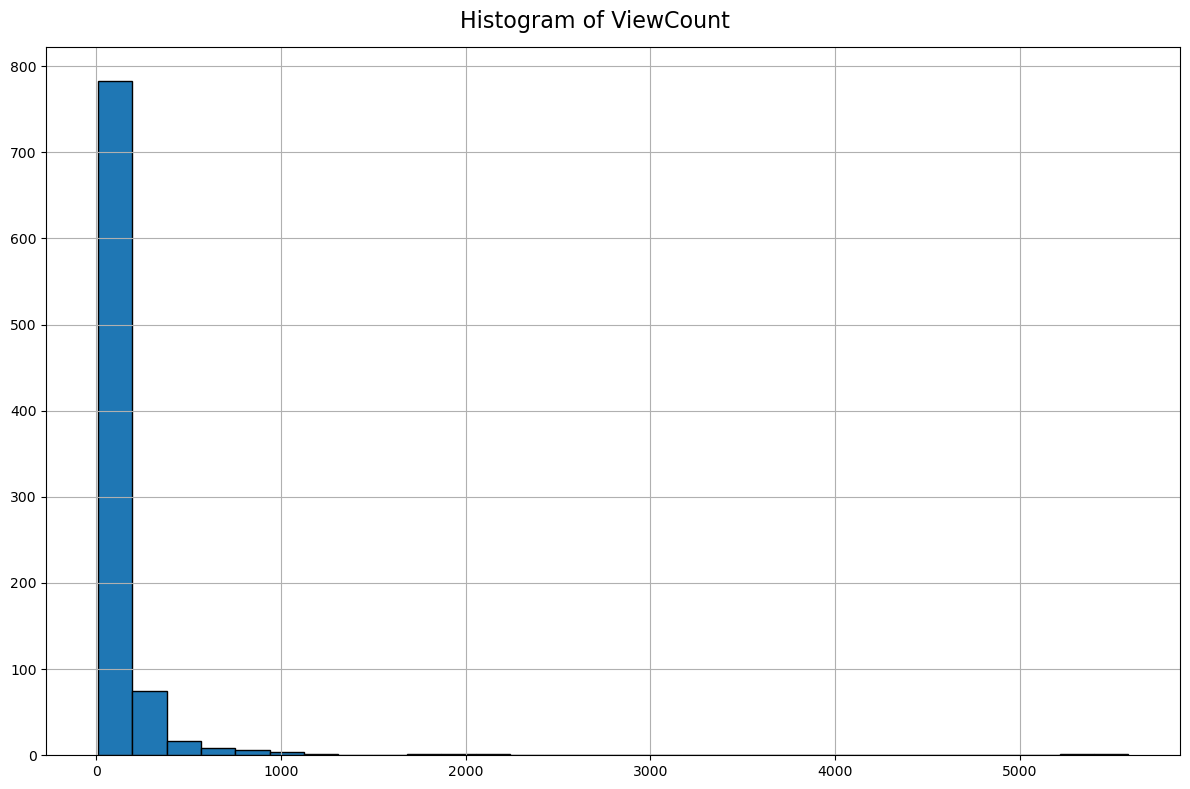

In [ ]:
# Plot histogram
features['ViewCount'].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Histogram of ViewCount", fontsize=16)
plt.tight_layout()
plt.show()


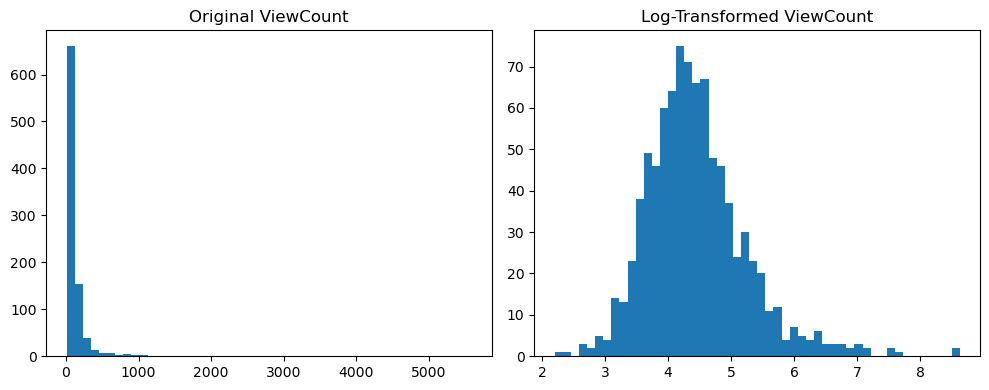

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(features['ViewCount'].dropna(), bins=50)
plt.title("Original ViewCount")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(features['ViewCount'].dropna()), bins=50)
plt.title("Log-Transformed ViewCount")

plt.tight_layout()
plt.show()


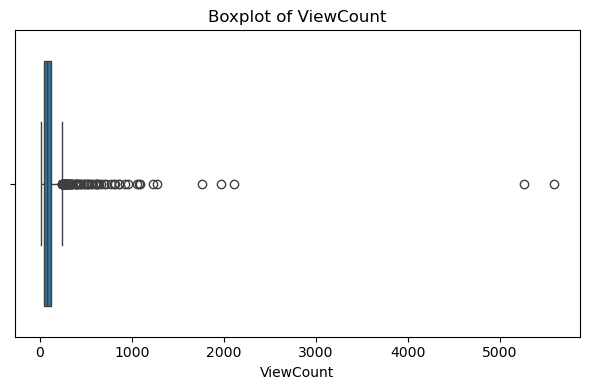

In [ ]:
# plot boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=features['ViewCount'])
plt.title(f"Boxplot of ViewCount")
plt.tight_layout()
plt.show()

Since the log-transformed ViewCount distribution appears roughly normal, it is reasonable to perform imputation on the log scale using statistical methods. This approach is especially valuable because it helps preserve the majority of the data, avoiding the loss of 66% due to missing values.

#### **Analyzing Log-Transformed ViewCount & Its Relationship with Other Features**

I create a new feature, `LogViewCount`, by applying a log transformation to `ViewCount`. Then, I plot scatter plots of `LogViewCount` against other numeric features to visually explore their relationships. Finally, I compute and visualize the correlation matrix using a heatmap to identify which features are most strongly related to `LogViewCount`.


In [ ]:
# Calculate LogViewCount and add it to the dataframe
features = features.copy()  # Create a copy

features.loc[:, 'LogViewCount'] = np.log1p(features['ViewCount'])


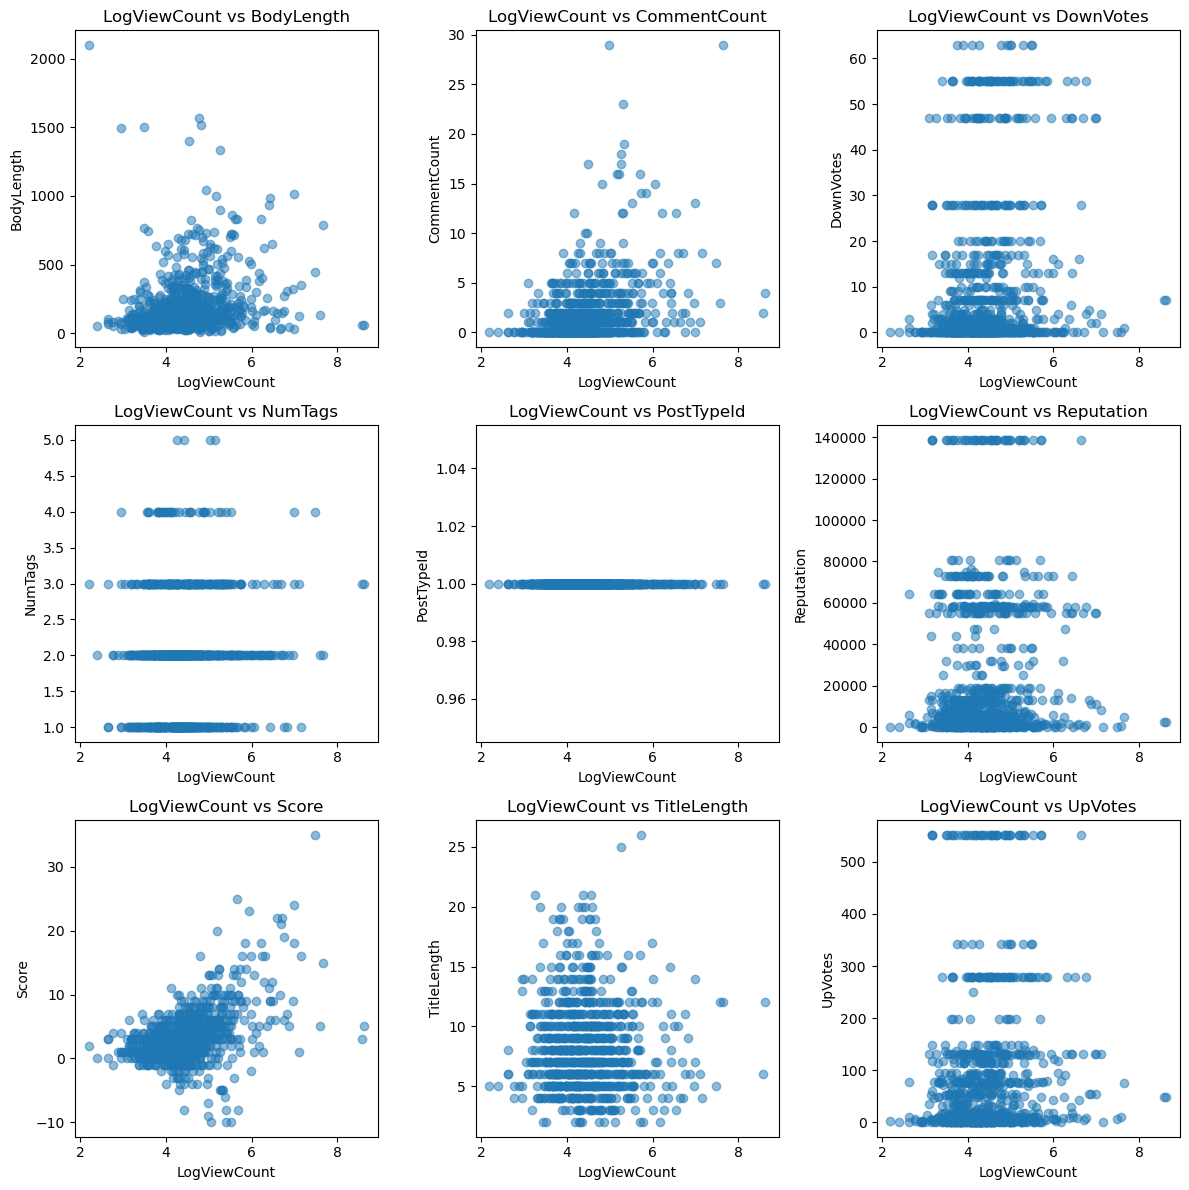

In [ ]:
# Select all numeric columns, including LogViewCount
numeric_columns = features.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.difference(['LogViewCount', 'ViewCount'])

# Calculate the number of rows and columns needed for subplots
n_cols = 3
n_rows = int(np.ceil(len(numeric_columns) / n_cols))  # Calculate the necessary number of rows

# Create a figure subplots
plt.figure(figsize=(12, 4 * n_rows))

# Create a scatter plot for LogViewCount with each numeric feature
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(features['LogViewCount'], features[col], alpha=0.5)
    plt.title(f"LogViewCount vs {col}")
    plt.xlabel("LogViewCount")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

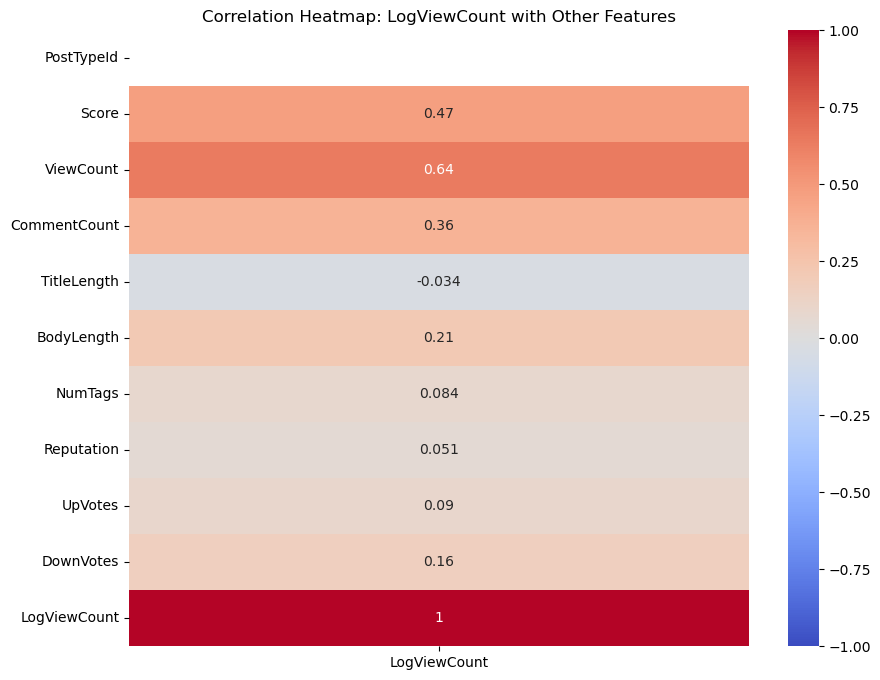

In [ ]:
numeric_columns = features.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix for the selected columns
corr_matrix = features[numeric_columns].corr()

# Create a heatmap to visualize the correlation between 'LogViewCount' and other features
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['LogViewCount']], annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)

plt.title('Correlation Heatmap: LogViewCount with Other Features')
plt.show()

The pairplots and heatmap show that `LogViewCount` is moderately correlated with features like `Score`, `CommentCount`, and `BodyLength`, while it has weaker correlations with `UpVotes` and `DownVotes`. Based on this insight, we’ll now use these variables as predictors in our regression model.


#### **Imputing Missing ViewCount Using Linear Regression**

To address the large number of missing values in the `ViewCount` variable, I first selected a subset of features (`Score`, `CommentCount`, `BodyLength`, `UpVotes`, and `DownVotes`) that showed some correlation with `LogViewCount`. I split the data into training and testing sets—using rows where `LogViewCount` is present to train a linear regression model and predicting it for rows where it's missing.

Once trained, I used the model to impute missing `LogViewCount` values, then applied the exponential transformation (`expm1`) to convert them back to the original `ViewCount` scale. I also evaluated the model's performance using MAE and RMSE on the training data to check its fit. Finally, I visualized the distribution of the completed `ViewCount` variable on the log scale to confirm its consistency.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepare the dataset by selecting relevant features
features_for_regression = features[['Score', 'CommentCount', 'BodyLength', 'UpVotes', 'DownVotes']].copy()
features_for_regression['LogViewCount'] = features['LogViewCount']

# Split the data into two sets
train_data = features_for_regression[features_for_regression['LogViewCount'].notna()]
test_data = features_for_regression[features_for_regression['LogViewCount'].isna()]

# Define the features and target
X_train = train_data[['Score', 'CommentCount', 'BodyLength', 'UpVotes', 'DownVotes']]
y_train = train_data['LogViewCount']

# Train a Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)


LinearRegression()

In [ ]:
# Predict the missing values for LogViewCount
X_test = test_data[['Score', 'CommentCount', 'BodyLength', 'UpVotes', 'DownVotes']]
predicted_logviewcount = regressor.predict(X_test)

# Impute the missing LogViewCount values
features.loc[features['LogViewCount'].isna(), 'LogViewCount'] = predicted_logviewcount

# Evaluate the model
y_pred_train = regressor.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 0.48105770929579966
Root Mean Squared Error (RMSE): 0.6537912568992419


Given that the LogViewCount scale ranges from 0 to 9, the Mean Absolute Error (MAE) of 0.481 and Root Mean Squared Error (RMSE) of 0.654 are relatively small and suggest that the model is performing quite well. RMSE of 0.654 is also relatively low given the scale. Since RMSE gives more weight to larger errors, this indicates that, while most of the predictions are close to the actual values, there are still some predictions that could be off by larger amounts (although the penalty is not overwhelming, given the small scale).

In [ ]:
# Apply the reverse log transformation for missing ViewCount values
features.loc[features['ViewCount'].isna(), 'ViewCount'] = np.expm1(features.loc[features['ViewCount'].isna(), 'LogViewCount'])


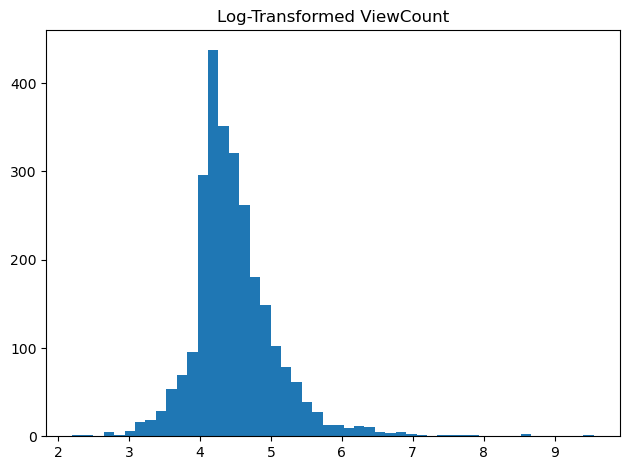

In [ ]:
plt.hist(np.log1p(features['ViewCount'].dropna()), bins=50)
plt.title("Log-Transformed ViewCount")

plt.tight_layout()
plt.show()

As a result of the above transformations, the **LogViewCount** distribution remains approximately normal even after imputation, indicating that the regression-based approach preserved the underlying data characteristics and worked effectively.

In [ ]:
# Total missing and percentage
missing_info = features.isnull().sum().to_frame(name="Missing Count")
missing_info["% Missing"] = (features.isnull().mean() * 100).round(2)
missing_info

Missing Count  % Missing
PostTypeId                0        0.0
Score                     0        0.0
ViewCount                 0        0.0
CommentCount              0        0.0
TitleLength               0        0.0
BodyLength                0        0.0
NumTags                   0        0.0
Reputation                0        0.0
UpVotes                   0        0.0
DownVotes                 0        0.0
LogViewCount              0        0.0
IsAnswered                0        0.0

The updated `missing_info` confirms that all missing values have been successfully handled, indicating a clean and complete dataset.


#### **Interactive Sankey Diagram for Data Flow and Missingness**
After cleaning and imputing the data, the Sankey diagram is used to visually summarize how missing values are handled at each stage. The raw dataset contains missing values in key features such as `Reputation`, `UpVotes`, `DownVotes`, `ViewCount`, and `IsAnswered`. Addressing these gaps is crucial to ensure the reliability of downstream analysis and model performance.

The first step imputes missing values for `Reputation`, `UpVotes`, and `DownVotes`—features that are often interrelated and can be estimated using grouped statistics or logical assumptions. The second step handles missing values in `ViewCount` through regression-based imputation, using other available features to make more informed predictions. For the `IsAnswered` column, which serves as the target for classification, imputation is avoided to maintain label integrity, and rows with missing values are dropped.



In [ ]:
# Set raw total
raw_total = 2687

# Example values you might have calculated earlier
imputed_count = 32          # median imputation count
regressed_count = 1787      # regression imputation count
dropped_count = 0           # no rows dropped
final_count = raw_total     # final cleaned data count equals raw_total here


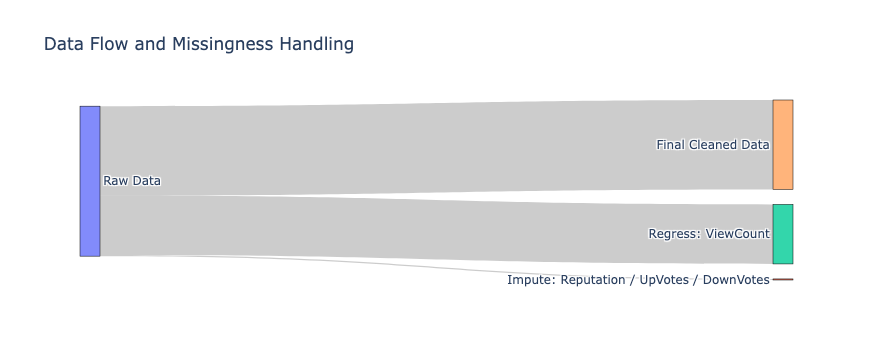

In [ ]:
import plotly.graph_objects as go

# Labels for each stage
labels = [
    "Raw Data",
    "Impute: Reputation / UpVotes / DownVotes",
    "Regress: ViewCount",
    "Drop: Missing IsAnswered",
    "Final Cleaned Data"
]

# Mapping each flow (source → target)
source = [0, 0, 0, 0]  # All from Raw Data
target = [1, 2, 3, 4]
value = [imputed_count, regressed_count, dropped_count, final_count]

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title_text="Data Flow and Missingness Handling", font_size=12)
fig.show()


The Sankey diagram presents a clear flow from the raw data to the final cleaned dataset, highlighting how many rows are processed at each step. The figure visually illustrates the flow of data through the cleaning and imputation process. It shows how much of the data was already complete, how much required logistic regression-based imputation for `ViewCount`, and how much required median imputation for `Reputation`, `UpVotes`, and `DownVotes`. From the diagram, we can clearly see that less than half of the dataset was already clean. Approximately 1,787 rows underwent regression-based imputation, while only 32 rows required median imputation. This highlights that missingness was minimal for most features and concentrated primarily in `ViewCount`.



### **Exploratory Data Analysis (EDA) and Data Visualization for Classification**
#### **PCA Biplot for Feature Relationships and Class Separation**
To understand the linear separability and contributions of individual features, we used a PCA biplot. Data points (StackExchange posts) are projected into 2D space based on their principal components, colored by their `IsAnswered` status. This code uses PCA to reduce five post-related features to two principal components for visualization. After standardizing the data, it projects posts into a 2D space and colors them by whether they were answered.

Feature vectors (arrows) are drawn to indicate the direction and influence of each original feature in the PCA space. This results in a biplot—a compact visual tool for understanding both the distribution of the data and how each feature contributes to it.

In [ ]:
# Select features and target
biplot_features = ['Score', 'CommentCount', 'BodyLength', 'UpVotes', 'DownVotes']
X = features[biplot_features].copy()
y = merged_df.loc[X.index, 'IsAnswered']  # Align index

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


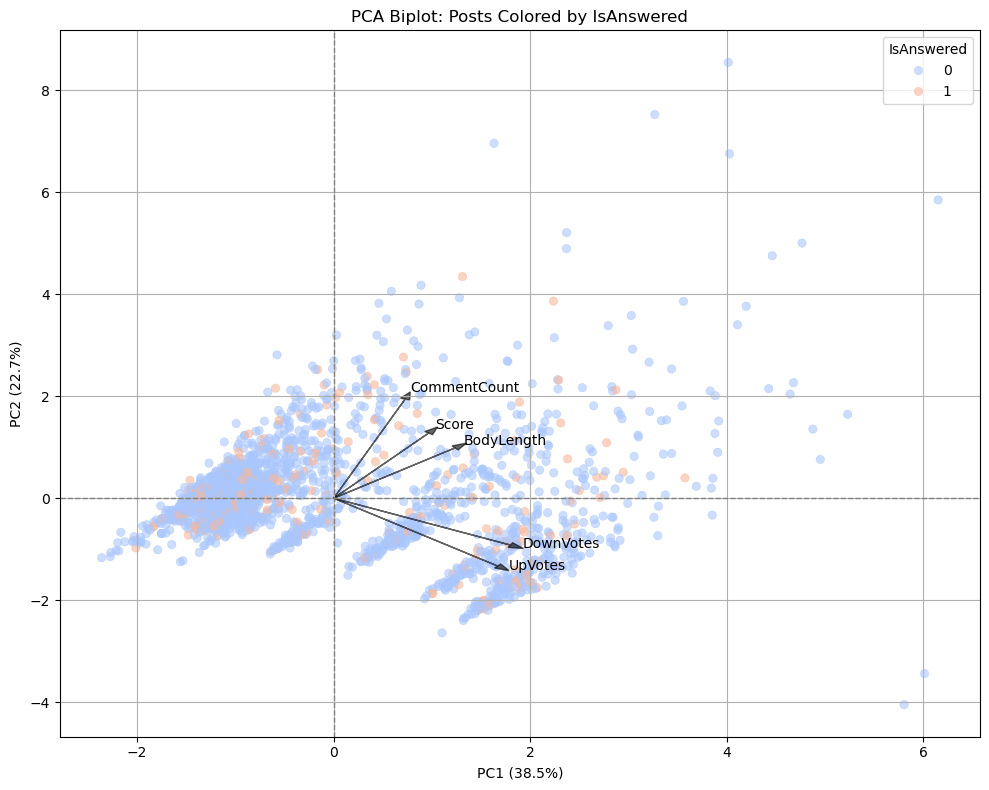

In [ ]:
# Start plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="coolwarm", alpha=0.6, edgecolor=None)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA Biplot: Posts Colored by IsAnswered")

# Plot the feature vectors
for i, feature in enumerate(biplot_features):
    plt.arrow(0, 0,
              pca.components_[0, i]*3,
              pca.components_[1, i]*3,
              color='black', alpha=0.6, head_width=0.1)
    plt.text(pca.components_[0, i]*3.2,
             pca.components_[1, i]*3.2,
             feature, color='black', fontsize=10)

plt.grid(True)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

The PCA biplot shows that *CommentCount*, *Score*, and *BodyLength* are positively correlated, as indicated by their similar arrow directions and lengths. This suggests these features tend to vary together and contribute similarly to the first two principal components. In contrast, *UpVotes* and *DownVotes* point in a different direction, with longer arrows and close angles between them, indicating they form another correlated group with greater influence on the variance. Overall, the plot reveals two distinct clusters of related features.


#### **Decision Boundary Visualizations**
In this step, we fit a Logistic Regression model on the 2D PCA-transformed data. Since PCA reduced the original feature space to two principal components, this allows us to visualize how a simple linear classifier separates the data points based on the target variable (IsAnswered).

The reason for doing this after the PCA biplot is to examine whether the classes are linearly separable in the reduced space. By plotting the decision boundary, we can visually assess the effectiveness of the PCA-reduced features for classification. If the boundary cleanly separates the two classes, it suggests that PCA has preserved relevant structure for the classification task, making it useful for both interpretation and dimensionality reduction.


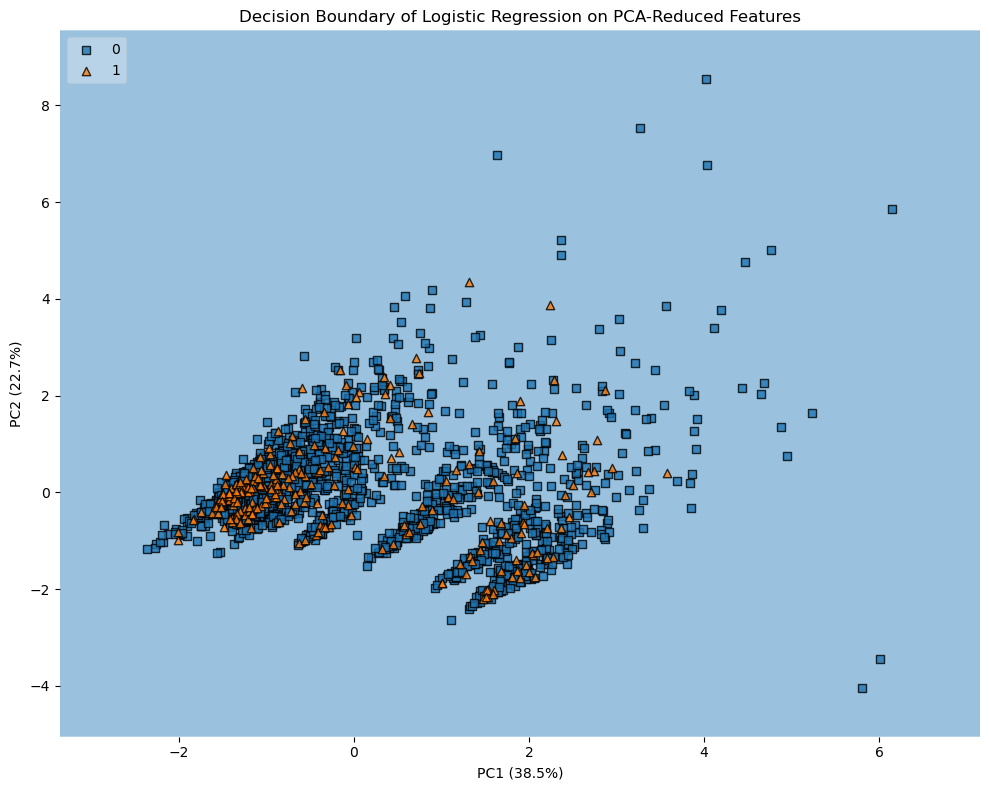

In [ ]:

# Ensure PCA-transformed features and labels are ready
X_pca_np = X_pca.astype(np.float32)
y_binary = y.astype(int).values

# Fit a simple model (Logistic Regression)
clf = LogisticRegression()
clf.fit(X_pca_np, y_binary)

# Plot the decision boundary
plt.figure(figsize=(10, 8))
plot_decision_regions(X_pca_np, y_binary, clf=clf, legend=2)
plt.title("Decision Boundary of Logistic Regression on PCA-Reduced Features")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.tight_layout()
plt.show()


Answered posts (triangles) and unanswered posts (squares) are visibly distributed across all five regions, with noticeable overlap—particularly in the first two cones, which also contain the highest concentration of answered posts. This indicates that, while there is some structure in the data, the classes are not clearly separated.

This visualization helps us understand how features relate in terms of variance and class spread. It suggests that classification might be challenging due to overlap, and motivates the next step: fitting a classifier to assess how well the PCA-reduced features can separate answered from unanswered posts.

### **Classification: Will a Post Get an Accepted Answer?**
#### **Data Prep & t-SNE: Answered vs. Unanswered Posts**
I begin by merging the `IsAnswered` target variable into the feature set, ensuring that only rows with known answered status are retained. I then define `X` as the feature matrix (excluding target and regression-specific columns) and `y` as the classification target. The dataset is split into training and test sets using stratified sampling to maintain class distribution.

Next, I standardize the features using `StandardScaler` to prepare the data for modeling and visualization. To explore any inherent structure in the data related to answered status, I apply t-SNE (a dimensionality reduction technique) on the scaled features and plot the resulting 2D representation. This scatter plot helps visually assess how separable the answered and unanswered posts might be based on the selected features.


In [ ]:
# Merge IsAnswered into the feature set
features.loc[:, 'IsAnswered'] = merged_df['IsAnswered']

# Drop rows with missing IsAnswered
features = features.dropna(subset=['IsAnswered'])


In [ ]:
X = features.drop(columns=['IsAnswered', 'ViewCount', 'LogViewCount'])  # Excluding target + regression cols
y = features['IsAnswered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Visualise with t-SNE
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['IsAnswered'] = y.values


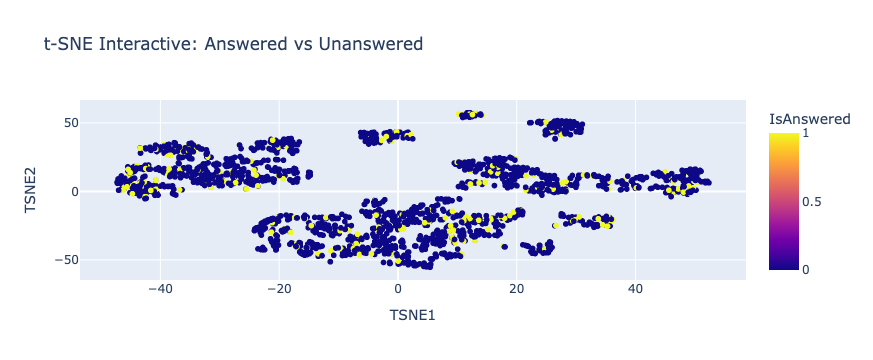

In [ ]:
import plotly.express as px
# Combine t-SNE results with original metadata
tsne_df['Score'] = features['Score'].values
tsne_df['UpVotes'] = features['UpVotes'].values
tsne_df['DownVotes'] = features['DownVotes'].values

fig = px.scatter(tsne_df, x='TSNE1', y='TSNE2', color='IsAnswered',
                 hover_data=['Score', 'UpVotes', 'DownVotes'],
                 title='t-SNE Interactive: Answered vs Unanswered')
fig.show()



Each point represents a post, with colors indicating the `IsAnswered` status — blue for unanswered (0) and yellow for answered (1). From the plot, we observe a clear class imbalance, with unanswered posts dominating the distribution. More importantly, the answered posts are spread throughout the feature space, showing no clear clusters or separation from unanswered ones. This overlap suggests that our current features might not provide strong class separability, potentially making it difficult for classification models to clearly distinguish between the two classes.

#### **Basic Random forest Classifier**
First, we use a basic classifier — a Random Forest — to establish a baseline. We train the model on the scaled training data and then predict the IsAnswered status on the scaled test set.

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)


In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[370   5]
 [ 49   2]]
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       375
         1.0       0.29      0.04      0.07        51

    accuracy                           0.87       426
   macro avg       0.58      0.51      0.50       426
weighted avg       0.81      0.87      0.83       426



The confusion matrix shows the model performs well on unanswered posts but poorly on answered ones. It has high precision and recall for the majority class but very low recall (4%) for the minority class. Despite an overall accuracy of 87%, this is misleading due to class imbalance. The results highlight the model’s bias toward the majority class and the need for techniques like resampling or class weighting to better detect answered posts.

#### **Random forest Classifier with Hyperparameter Tuning**
Next, I will apply hyperparameter tuning using RandomizedSearchCV to optimize the Random Forest model. By exploring a wide range of parameters—including the number of trees, tree depth, minimum samples per split and leaf, max features, and class weighting—I aim to improve classification performance, especially for the minority class. After fitting the tuned model, I will evaluate its predictions on the test set to determine if these adjustments enhance overall and class-specific metrics.

In [ ]:
# Define the parameter space
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)



In [ ]:
# Perform random search
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=50, cv=5, scoring='f1_macro', random_state=42, n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1362f81a0>},
                   random_state=42, scoring='f1_macro')

In [ ]:
# Use best model
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
[[358  17]
 [ 48   3]]
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92       375
         1.0       0.15      0.06      0.08        51

    accuracy                           0.85       426
   macro avg       0.52      0.51      0.50       426
weighted avg       0.79      0.85      0.82       426



The result indicates that while the model maintains a good precision (0.88) and recall (0.95) for the majority class (unanswered posts), its performance on the minority class (answered posts) remains very poor, with precision of 0.15, recall of 0.06, and an F1-score of only 0.08. Overall accuracy slightly decreased to 85%, and the macro average F1-score is 0.50, showing that despite tuning, the model still struggles to correctly identify answered posts due to class imbalance.

#### **Random forest Classifier with SMOTE**
Due to the limited improvement after hyperparameter tuning, we will now explore resampling techniques to better address the class imbalance. Specifically, we will apply various SMOTE variants—SMOTE, ADASYN, SMOTEENN, and SMOTETomek—to oversample the minority class in the training data. SMOTE (Synthetic Minority Over-sampling Technique) works by generating synthetic examples for the minority class by interpolating between existing minority instances and their nearest neighbors. This helps the model learn a more generalizable decision boundary rather than simply memorizing rare cases.

For each method, we will resample the training set, retrain a Random Forest classifier with balanced class weights, and evaluate its performance on the test set using confusion matrices, classification reports, and AUC scores. This approach aims to improve the model’s ability to correctly identify the minority class (answered posts) by creating a more balanced training dataset.

In [ ]:
# SMOTE variants
smote_methods = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

In [ ]:
for name, sampler in smote_methods.items():
    print(f"\n--- {name} ---")

    X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)

    clf = RandomForestClassifier(random_state=42, class_weight='balanced')
    clf.fit(X_resampled, y_resampled)

    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)[:, 1]

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


--- SMOTE ---
[[352  23]
 [ 47   4]]
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       375
         1.0       0.15      0.08      0.10        51

    accuracy                           0.84       426
   macro avg       0.52      0.51      0.51       426
weighted avg       0.79      0.84      0.81       426

AUC Score: 0.4760

--- ADASYN ---
[[357  18]
 [ 46   5]]
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       375
         1.0       0.22      0.10      0.14        51

    accuracy                           0.85       426
   macro avg       0.55      0.53      0.53       426
weighted avg       0.81      0.85      0.82       426

AUC Score: 0.4936

--- SMOTEENN ---
[[273 102]
 [ 38  13]]
              precision    recall  f1-score   support

         0.0       0.88      0.73      0.80       375
         1.0       0.11      0.25      0.16        51

    accuracy                

The results from applying different SMOTE variants show only marginal improvements in identifying the minority class.

- With SMOTE, the model achieved a recall of 8% and an F1-score of 0.10 for answered posts, with an AUC score of 0.4760.
- ADASYN performed slightly better, improving recall to 10% and F1-score to 0.14, with an AUC of 0.4936.
- However, SMOTEENN showed a trade-off with a drop in overall accuracy to 67%, but a modest recall increase to 25% for the minority class, though precision remained low and AUC at 0.4656.
- SMOTETomek resulted in low recall (4%) and F1-score (0.05), with an AUC of 0.4555.

Overall, while some SMOTE variants slightly improved recall, the gains are limited, and the model still struggles to effectively separate the minority class, as reflected in low precision, recall, and AUC scores.

#### **LGBMClassifier with SMOTE**
Because of the limited improvements seen with Random Forest and SMOTE variants, we will now apply the same resampling techniques combined with a LightGBM classifier.

LightGBM (Light Gradient Boosting Machine) is a powerful, efficient gradient boosting framework that builds decision trees in a leaf-wise fashion, often leading to faster training and better accuracy compared to traditional boosting methods. It is well-suited for handling large datasets and imbalanced classes.

By combining SMOTE methods with LightGBM, we aim to improve the model’s ability to correctly predict the minority class and achieve better overall performance. For each SMOTE variant, we will resample the training data, train the LightGBM model with balanced class weights, and evaluate its results using confusion matrices, classification reports, and AUC scores.


In [ ]:
for name, sampler in smote_methods.items():
    print(f"\n--- {name} with LightGBM ---")

    X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)

    clf = LGBMClassifier(random_state=42, class_weight='balanced')
    clf.fit(X_resampled, y_resampled)

    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)[:, 1]

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {roc_auc_score(y_test, y_prob):.4f}")



--- SMOTE with LightGBM ---
[LightGBM] [Info] Number of positive: 1498, number of negative: 1498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1842
[LightGBM] [Info] Number of data points in the train set: 2996, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[[358  17]
 [ 50   1]]
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91       375
         1.0       0.06      0.02      0.03        51

    accuracy                           0.84       426
   macro avg       0.47      0.49      0.47       426
weighted avg       0.78      0.84      0.81       426

AUC Score: 0.5121

--- ADASYN with LightGBM ---
[LightGBM] [Info] Number of positive: 1479, number of negative: 1498
[Ligh

Using LightGBM with different SMOTE-based resampling methods, we see that overall accuracy remains high (74–85%), but the model still struggles with the minority class (answered posts). Recall and F1-scores for answered posts stay very low (mostly under 12%), indicating poor detection despite some minor improvements with SMOTEENN. AUC scores hover around 0.51–0.52, showing limited ability to distinguish classes. This suggests that while resampling helps balance the data, further improvements or feature enhancements are needed to better identify answered posts.


#### **XGBClassifier with SMOTE**
Finally, we will try using XGBoost combined with the same SMOTE-based resampling methods to see if this improves performance.

XGBoost (Extreme Gradient Boosting) is a powerful and efficient gradient boosting algorithm widely used for classification and regression tasks. It builds an ensemble of decision trees sequentially, where each new tree tries to correct errors made by previous trees. XGBoost includes advanced features like regularization, handling missing values, and built-in support for imbalanced data via parameters like scale_pos_weight. This makes it especially effective for complex datasets with class imbalance.

To address the imbalance, we calculate the scale_pos_weight based on the ratio of negative to positive samples in the training set. For each SMOTE variant, we train an XGBoost classifier with this weighting and evaluate its predictions on the test set. This method aims to improve detection of the minority class and enhance overall model performance metrics such as recall and AUC.

In [ ]:
# Calculate scale_pos_weight for imbalance
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

for name, sampler in smote_methods.items():
    print(f"\n--- {name} with XGBoost ---")

    X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)

    clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=pos_weight
    )
    clf.fit(X_resampled, y_resampled)

    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)[:, 1]

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {roc_auc_score(y_test, y_prob):.4f}")



--- SMOTE with XGBoost ---


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:24:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[310  65]
 [ 45   6]]
              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85       375
         1.0       0.08      0.12      0.10        51

    accuracy                           0.74       426
   macro avg       0.48      0.47      0.47       426
weighted avg       0.78      0.74      0.76       426

AUC Score: 0.5128

--- ADASYN with XGBoost ---
[[318  57]
 [ 43   8]]
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86       375
         1.0       0.12      0.16      0.14        51

    accuracy                           0.77       426
   macro avg       0.50      0.50      0.50       426
weighted avg       0.79      0.77      0.78       426

AUC Score: 0.5203

--- SMOTEENN with XGBoost ---


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:24:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:24:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:24:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[255 120]
 [ 36  15]]
              precision    recall  f1-score   support

         0.0       0.88      0.68      0.77       375
         1.0       0.11      0.29      0.16        51

    accuracy                           0.63       426
   macro avg       0.49      0.49      0.46       426
weighted avg       0.78      0.63      0.69       426

AUC Score: 0.5080

--- SMOTETomek with XGBoost ---
[[308  67]
 [ 43   8]]
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85       375
         1.0       0.11      0.16      0.13        51

    accuracy                           0.74       426
   macro avg       0.49      0.49      0.49       426
weighted avg       0.79      0.74      0.76       426

AUC Score: 0.5181


Using XGBoost with SMOTE variants, the accuracy ranged from 63% to 77%, with the best minority class recall reaching 0.29 using SMOTEENN. AUC scores stayed around 0.51 to 0.52, indicating only modest improvements in identifying the minority class. Overall, XGBoost combined with these resampling methods showed slight gains in minority class detection compared to previous models but still faced challenges in balancing precision and recall effectively.

"Despite using multiple classifiers and advanced oversampling techniques, the model struggled to reliably predict whether a post would get an accepted answer."

"This suggests that the existing structured features (like TitleLength, Score, Tags, etc.) may not capture the true determinants of a post’s success — pointing to the importance of deeper textual or semantic analysis."

"From a data ethics perspective, predictive models like this must be handled with care — especially if used in recommendation or moderation systems. Misclassifications could inadvertently bias visibility or engagement on the platform."



#### **SHAP Plot with XGBoost for Model Interpretability**
To better understand why the models performed poorly on the minority class, we will apply SHAP (SHapley Additive exPlanations) to interpret the most successful model (XGBoost).

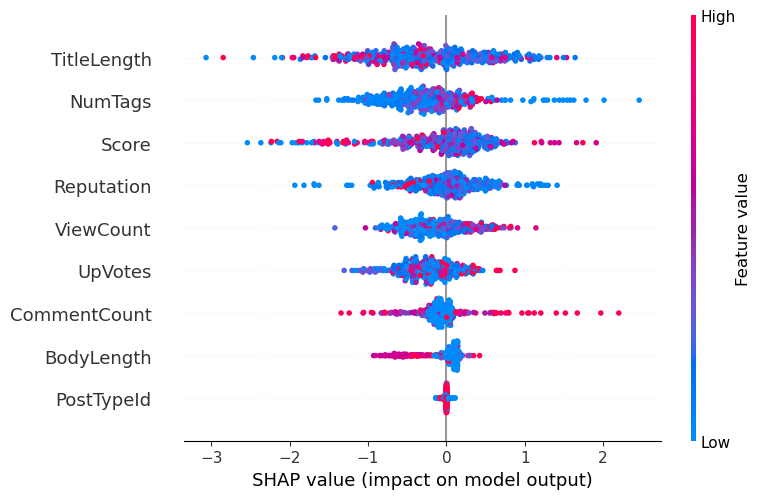

In [ ]:
# Train an example model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled)

# Summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=features.columns)


The above plot reveales that features like `TitleLength`, `CommentCount`, `Score`, and `BodyLength` are the strongest drivers of predicting answered posts, with higher values consistently favoring the majority class. In contrast, features such as `PostTypeId` and `Reputation` have minimal or inconsistent impact. This reinforces the hypothesis that the dataset lacks strong signals to distinguish unanswered posts, explaining why even advanced models with resampling struggled to improve recall without triggering a surge in false positives.


#### **SHAP Dependence Plot**
After plotting SHAP values from the XGBoost model, this step visualizes how the feature TitleLength influences predictions and how its effect interacts with Score.

By plotting TitleLength against its SHAP values, we see how changes in this feature impact the model’s output across data points. Coloring by Score reveals interaction effects, showing if and how the influence of TitleLength varies with different Score values.

This helps interpret the model by explaining not just the importance of TitleLength but also how it works together with Score to affect predictions, improving transparency and trust in the model’s decisions.


In [ ]:
# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

feature_x = 'TitleLength'  # x-axis
feature_color = 'Score'     # color


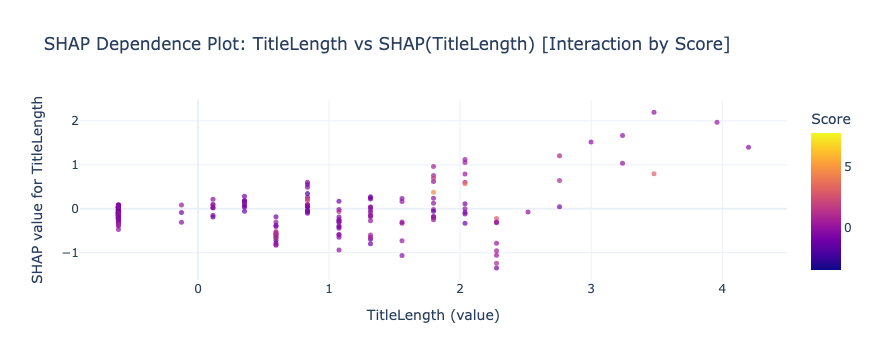

In [ ]:
import plotly.express as px

# Create a combined DataFrame for plotting
plot_df = X_test_df.copy()
plot_df["SHAP"] = shap_df[feature_x]

fig = px.scatter(
    data_frame=plot_df,
    x=feature_x,
    y="SHAP",
    color=feature_color,
    labels={
        feature_x: f"{feature_x} (value)",
        "SHAP": f"SHAP value for {feature_x}",
        feature_color: feature_color
    },
    title=f"SHAP Dependence Plot: {feature_x} vs SHAP({feature_x}) [Interaction by {feature_color}]",
    hover_data=plot_df.columns,
    template="plotly_white"
)

fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.show()


The plot reveals that most data points have TitleLength values between 0 and 2.2, with the majority associated with lower Score values (indicated by blue to purple colors). There are very few points with high scores (orange to yellow), suggesting that longer titles are less common or less associated with high scores in this dataset.

A small group of data points appears around -0.5 on the TitleLength axis, which may indicate some normalized or transformed values below zero, and very few values extend beyond 2.5, showing that extremely long titles are rare.

Overall, this means that most posts have relatively short titles and tend to receive lower scores, while high-scoring posts with longer titles are uncommon in the sample.


### **Interactive Custom Dashboard for Model Comparison**
In this section, I am preparing a comprehensive dashboard to evaluate and compare the performance of different classification models. The process begins by loading two datasets—one containing various performance scores (Model_Scores.csv) and another containing the corresponding confusion matrices (con_mat.csv) for each model.

Next, I parse the confusion matrix strings into structured data (lists of integers) to be usable in visualizations. I then extract the list of model names to populate dropdown menus, which will allow users to toggle between different models in the dashboard.

In [ ]:
# Load CSV files
scores_df = pd.read_csv("Model_Scores.csv")
conmat_df = pd.read_csv("con_mat.csv")

# Parse Confusion Matrix string into list of integers
conmat_df["ParsedMatrix"] = conmat_df["Confusion Matrix (TN, FP, FN, TP)"].apply(eval)

# Extract model names for dropdown
model_options = scores_df["Model Variant"].tolist()


For each model, I create two types of visualizations:

- Bar Charts showing five performance metrics—Accuracy, Precision (for class 1), Recall (for class 1), F1-score (for class 1), and AUC.

- Heatmaps representing the confusion matrix of each model, visually conveying the number of true positives, false positives, true negatives, and false negatives.

In [ ]:
# Prepare figures for all models upfront
metrics_figs = []
confmat_figs = []

for model in model_options:
    row = scores_df[scores_df["Model Variant"] == model].iloc[0]
    auc_val = pd.to_numeric(row["AUC"], errors='coerce')
    metrics_fig = go.Figure(data=[
        go.Bar(
            x=["Accuracy", "Precision (1)", "Recall (1)", "F1-score (1)", "AUC"],
            y=[
                row["Accuracy"],
                row["Precision (1)"],
                row["Recall (1)"],
                row["F1-score (1)"],
                auc_val if not np.isnan(auc_val) else 0

            ],
            marker_color=["#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A"]
        )
    ])
    metrics_fig.update_layout(title=f"Performance Metrics for {model}", yaxis=dict(range=[0,1]))

    cm_row = conmat_df[conmat_df["Model Variant"] == model].iloc[0]
    cm = cm_row["ParsedMatrix"]
    tn, fp = cm[0]
    fn, tp = cm[1]
    z = [[tn, fp], [fn, tp]]
    labels = ["Pred 0", "Pred 1"]
    cm_fig = go.Figure(data=go.Heatmap(
        z=z,
        x=labels,
        y=["Actual 0", "Actual 1"],
        colorscale="Blues",
        text=[[str(val) for val in row] for row in z],
        texttemplate="%{text}",
        showscale=False
    ))
    cm_fig.update_layout(title=f"Confusion Matrix: {model}")

    metrics_figs.append(metrics_fig)
    confmat_figs.append(cm_fig)


All these visual elements are stored in lists and used to build interactive dropdowns. These dropdowns allow users to switch between models dynamically and view their respective scores and confusion matrices in a consistent and centralized format.

In [ ]:
# Create the figure with buttons to toggle between models
metrics_figs = []
confmat_figs = []

for model in model_options:
    row = scores_df[scores_df["Model Variant"] == model].iloc[0]
    auc_val = pd.to_numeric(row["AUC"], errors='coerce')

    # Metrics figure
    metrics_fig = go.Figure(data=[
        go.Bar(
            x=["Accuracy", "Precision (1)", "Recall (1)", "F1-score (1)", "AUC"],
            y=[
                row["Accuracy"],
                row["Precision (1)"],
                row["Recall (1)"],
                row["F1-score (1)"],
                auc_val if not np.isnan(auc_val) else 0
            ],
            marker_color=["#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A"]
        )
    ])
    metrics_fig.update_layout(title=f"Performance Metrics for {model}", yaxis=dict(range=[0,1]))

    # Confusion matrix figure
    cm_rows = conmat_df[conmat_df["Model Variant"] == model]
    if cm_rows.empty:
        print(f"Warning: No confusion matrix found for model '{model}'")
        continue
    cm_row = cm_rows.iloc[0]

    # Check if ParsedMatrix is string
    if isinstance(cm_row["ParsedMatrix"], str):
        cm = ast.literal_eval(cm_row["ParsedMatrix"])
    else:
        cm = cm_row["ParsedMatrix"]

    tn, fp = cm[0]
    fn, tp = cm[1]

    z = [[tn, fp], [fn, tp]]
    labels = ["Pred 0", "Pred 1"]

    cm_fig = go.Figure(data=go.Heatmap(
        z=z,
        x=labels,
        y=["Actual 0", "Actual 1"],
        colorscale="Blues",
        text=[[str(val) for val in row] for row in z],
        texttemplate="%{text}",
        showscale=False
    ))
    cm_fig.update_layout(title=f"Confusion Matrix: {model}")

    metrics_figs.append(metrics_fig)
    confmat_figs.append(cm_fig)


The final output is an interactive dashboard containing two figures: one for performance metrics and one for confusion matrices, both updated via dropdown menus. This setup provides a clear, side-by-side comparison of model behavior and classification effectiveness, making it easier to select the best-performing model.

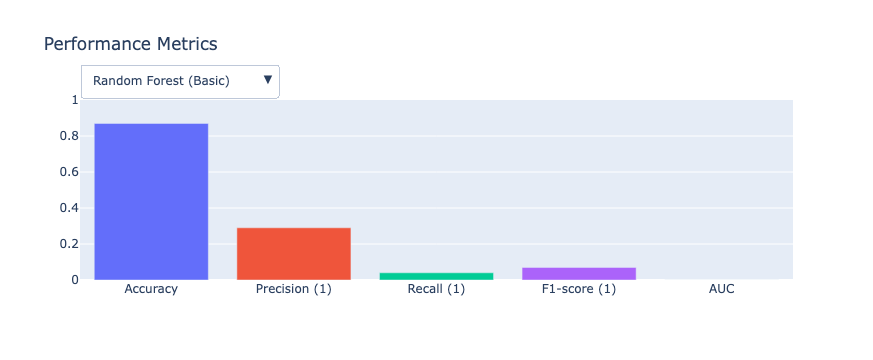

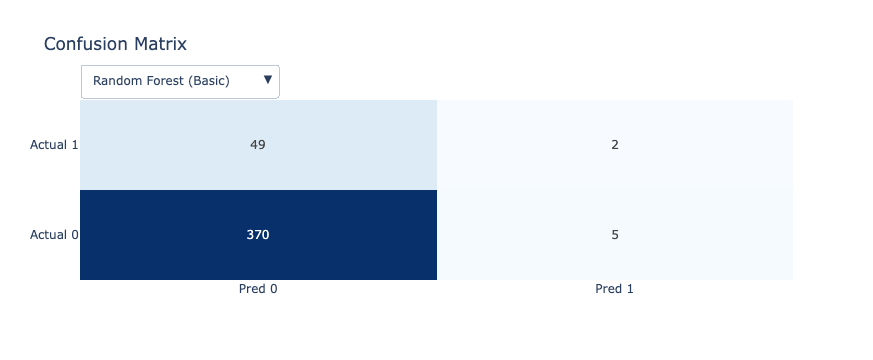

In [ ]:
# Initialize with first model's data
fig_metrics = metrics_figs[0]
fig_confmat = confmat_figs[0]

# Create buttons for dropdown
buttons_metrics = []
buttons_confmat = []

for i, model in enumerate(model_options):
    buttons_metrics.append(dict(
        method="restyle",
        args=[{"y": [metrics_figs[i].data[0].y]}, [0]],
        label=model
    ))
    buttons_confmat.append(dict(
        method="restyle",
        args=[
            {
                "z": confmat_figs[i].data[0].z,
                "text": [[str(val) for val in row] for row in confmat_figs[i].data[0].z]
            },
            [0]
        ],
        label=model
    ))

# Update layout for metrics figure
fig_metrics.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons_metrics,
        x=0,
        y=1.2,
        xanchor="left",
        yanchor="top"
    )],
    yaxis=dict(range=[0,1]),
    title="Performance Metrics"
)

# Update layout for confusion matrix figure
fig_confmat.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons_confmat,
        x=0,
        y=1.2,
        xanchor="left",
        yanchor="top"
    )],
    title="Confusion Matrix"
)

# Show figures inline
fig_metrics.show()
fig_confmat.show()


### **Conclusion**

We explored the use of ensemble classifiers — Random Forest, LightGBM, and XGBoost — along with various resampling techniques to address class imbalance in predicting whether a post would be answered. Despite achieving high overall accuracy (\~85–87%), all models struggled to detect the minority class, with recall rarely exceeding 16%. This highlights a critical issue: the models learned patterns that favored the dominant class, offering little improvement even after tuning and resampling.

To better understand this limitation, SHAP analysis was applied to the final XGBoost model. It revealed that features like `TitleLength`, `NumTags`, `Score`, and `Reputation` had the most consistent positive impact on predictions. However, the remaining features showed minimal or inconsistent influence, confirming that the dataset lacks strong discriminatory power for the minority class.

These findings suggest that further improvements should focus on better feature engineering, collecting more representative data for the positive class, and exploring cost-sensitive or anomaly detection approaches. Simply relying on more complex models is not enough when the data does not support effective minority class learning.
